## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix, classification_report, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data & Drop NaN Values

In [2]:
df = pd.read_csv("C:/Users/park9/pytorch/AI_class/data/WISDM_ar_v1.1_raw.txt",
                header=None,
                names=['user_id', 'activity', 'timestamp', 'x', 'y', 'z'],
                on_bad_lines='skip')

df['z'] = df['z'].astype(str).str.replace(";", "", regex=False).astype(float)

df.head()

,user_id,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


## Drop NaN Values

In [3]:
print(df.isna().sum())
df = df.dropna()

user_id      0
activity     0
timestamp    0
x            0
y            0
z            1
dtype: int64


## Visualization

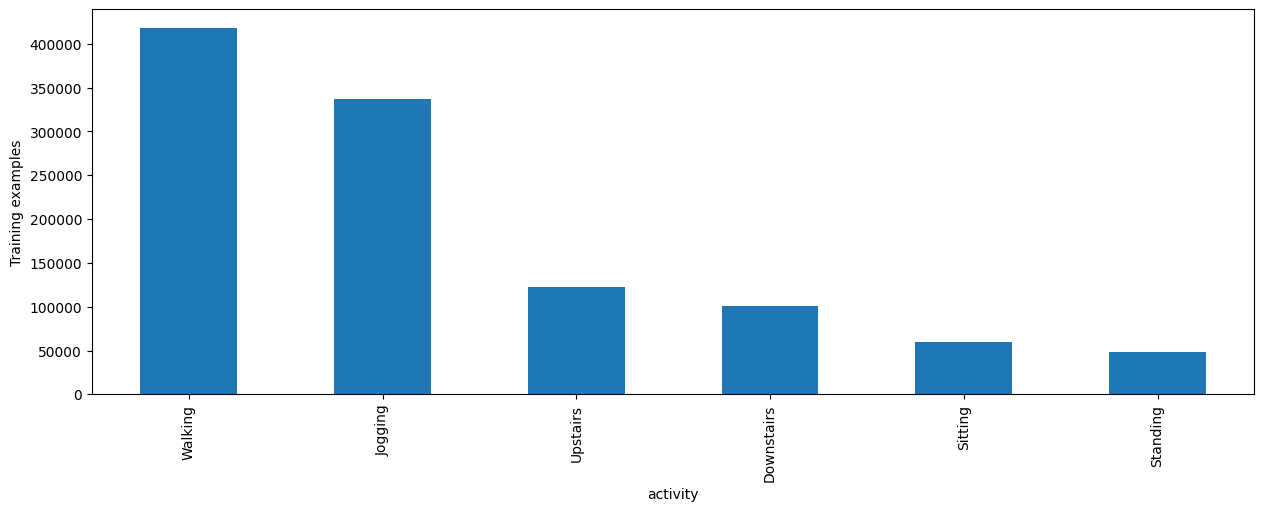

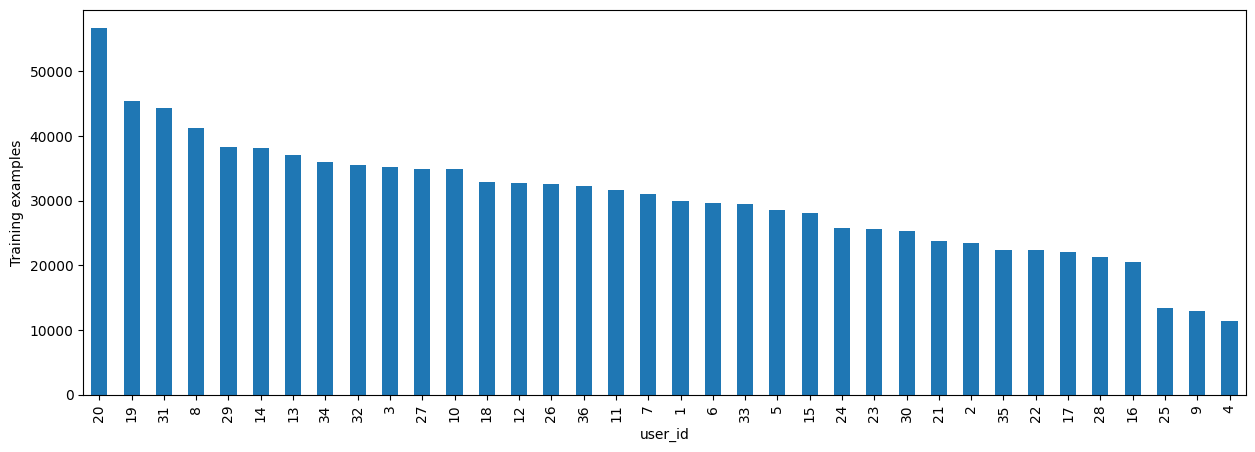

In [4]:
plt.figure(figsize=(15, 5))
plt.xlabel('Activity')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
df['user_id'].value_counts().plot(kind='bar')
plt.show()

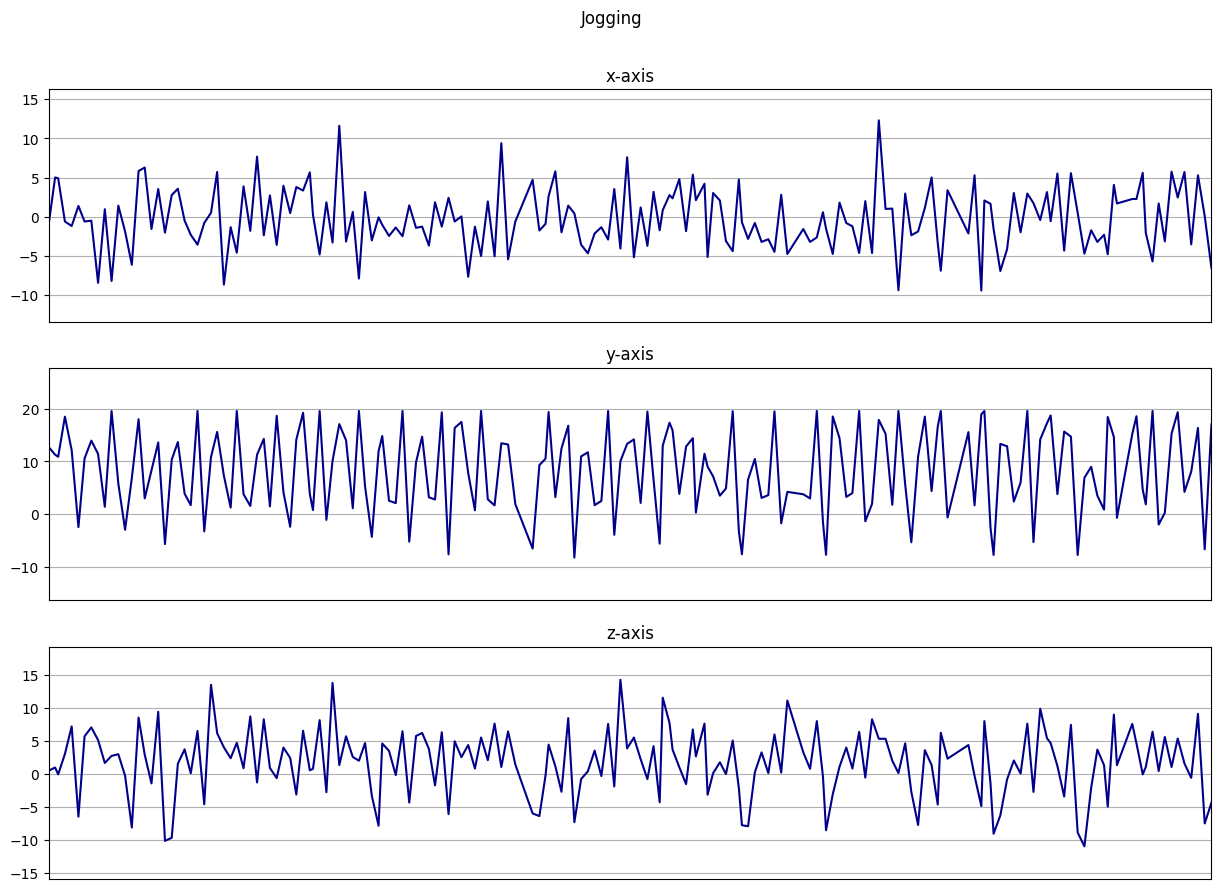

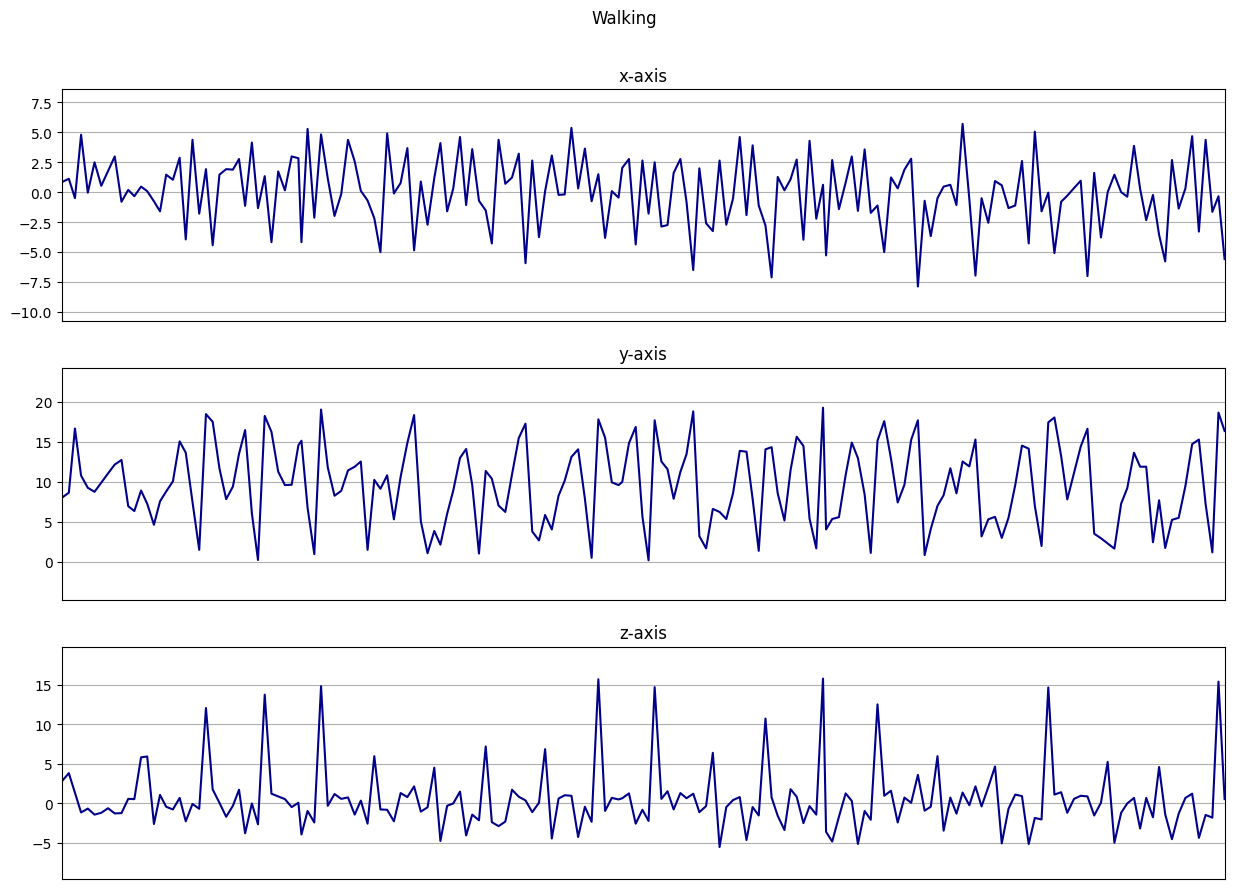

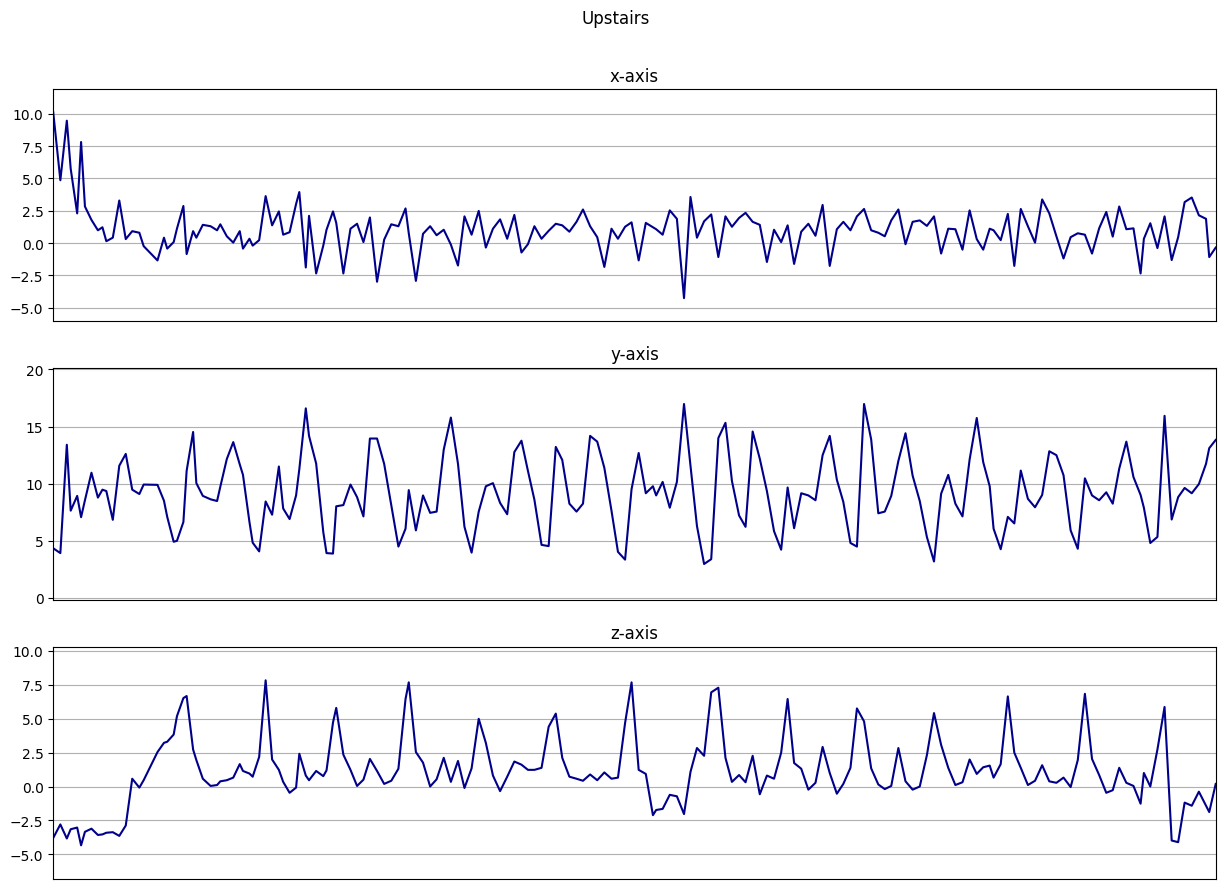

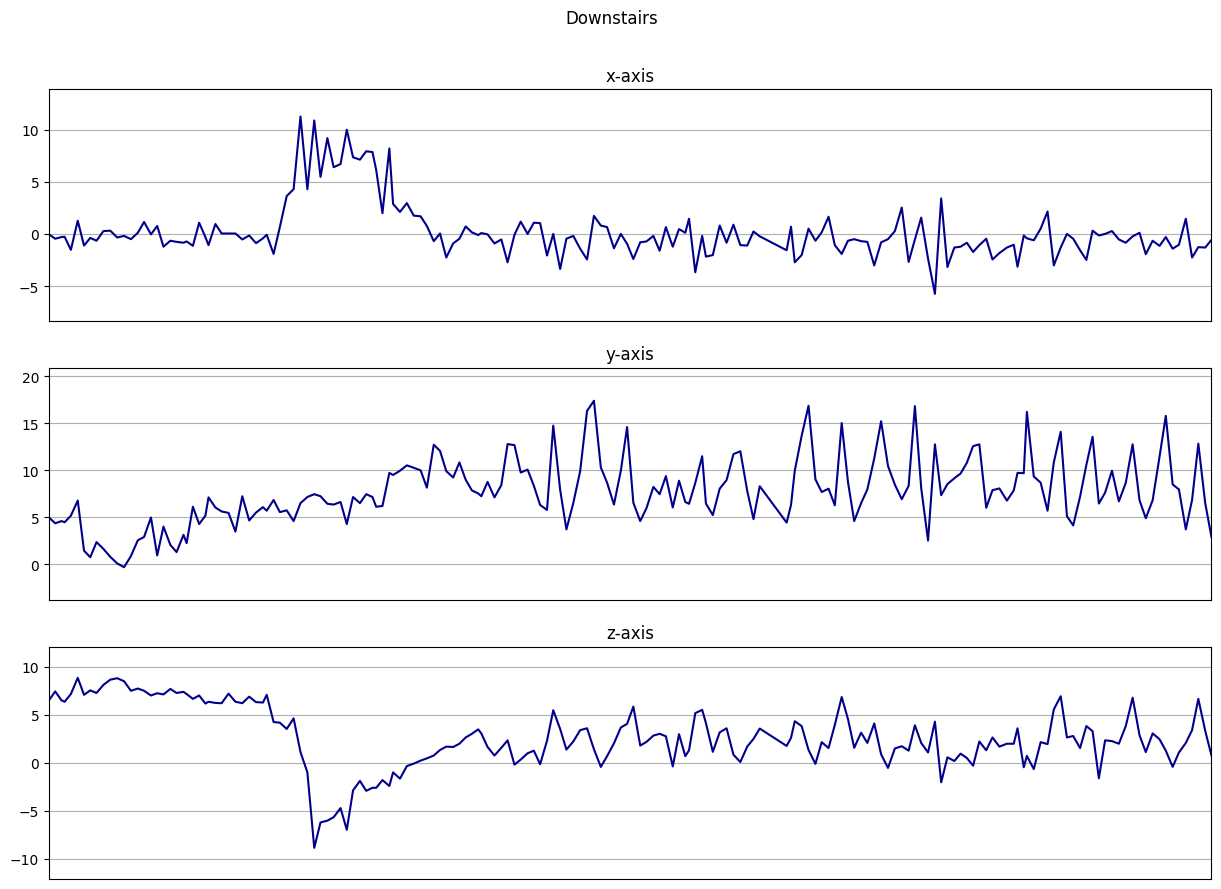

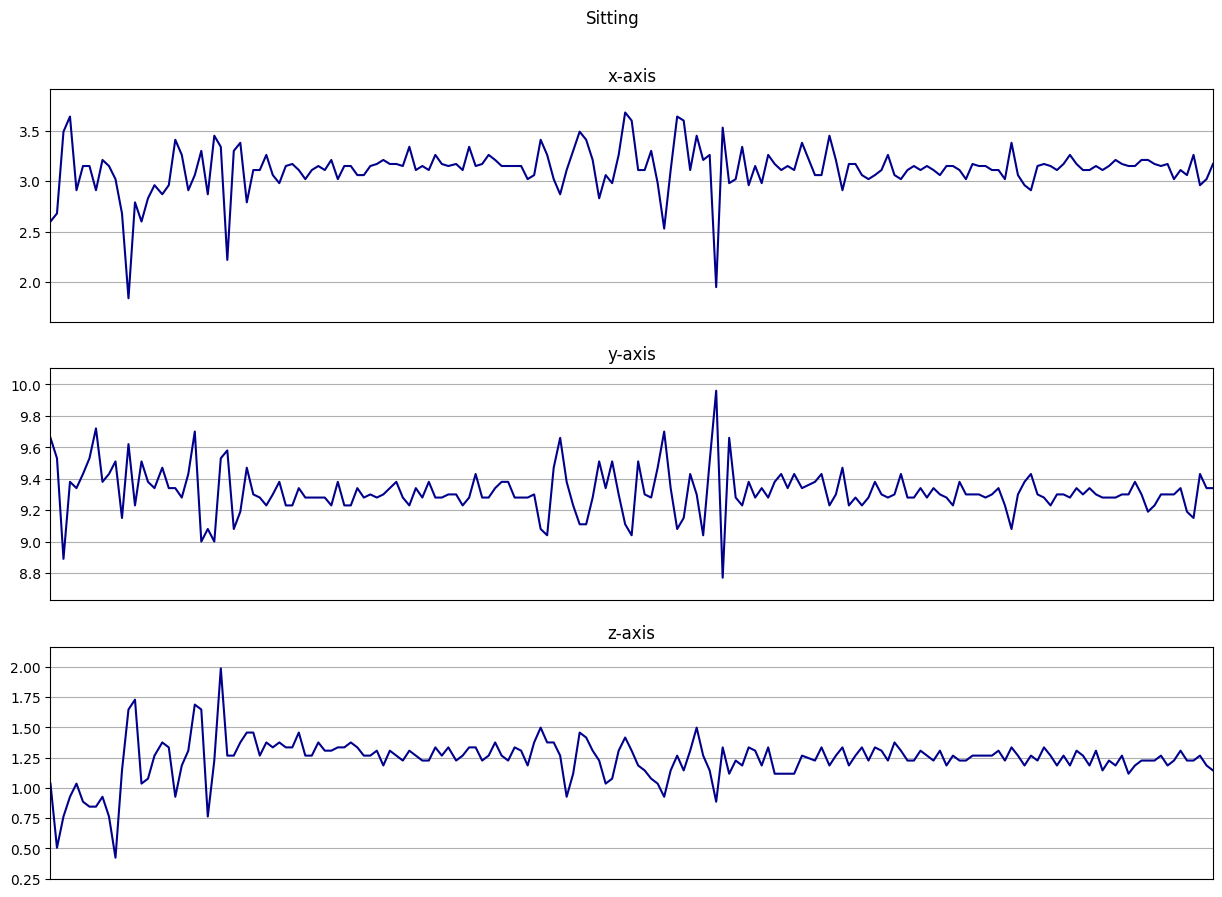

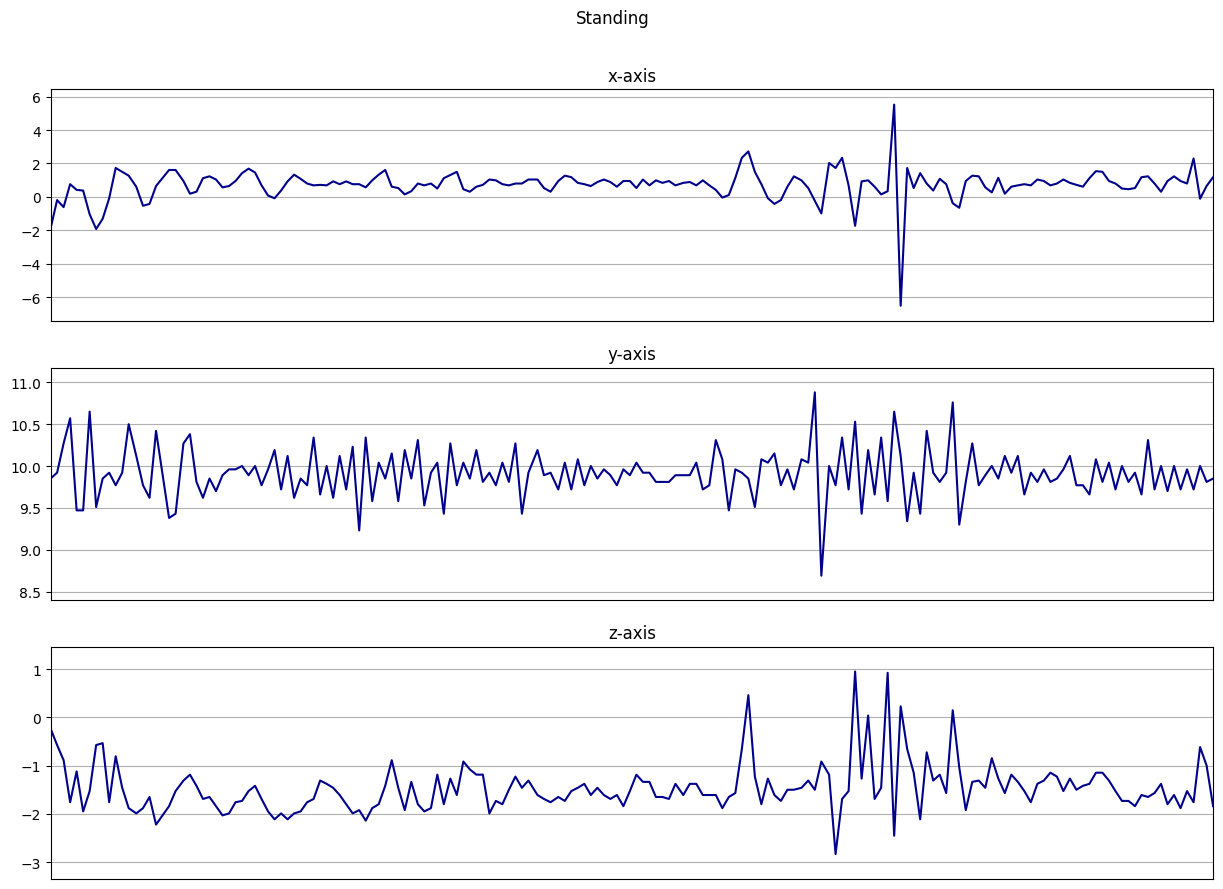

In [21]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'darkblue')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
for activity in df['activity'].unique():
    limit = df[df['activity'] == activity][:180]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit['timestamp'], limit['x'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['y'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['z'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

## Data Split

In [6]:
df_train = df[df['user_id'] <= 27].copy()
df_test = df[df['user_id'] > 27].copy()

In [7]:
print(df.shape)
print(df_train.shape)
print(df_test.shape)

(1086465, 6)
(801685, 6)
(284780, 6)


## Label Encoding

In [8]:
# Label Encoding
num_cols = ["x", "y", "z"]

le = LabelEncoder()
df_train["label"] = le.fit_transform(df_train["activity"])
df_test["label"]  = le.transform(df_test["activity"])

## Sliding Windows

In [9]:
def create_sliding_windows_with_group(df, window_size=80, step_size=40):
    data, labels, groups = [], [], []
    values = df[["x", "y", "z"]].values
    acts   = df["label"].values
    users  = df["user_id"].values

    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window = values[start:end]
        label  = np.argmax(np.bincount(acts[start:end]))
        user   = users[start]

        data.append(window)
        labels.append(label)
        groups.append(user)

    return np.array(data), np.array(labels), np.array(groups)

X, y, groups = create_sliding_windows_with_group(df_train)
X_test, y_test, groups_test = create_sliding_windows_with_group(df_test)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)
test_ds  = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

print("전체:", X.shape, y.shape, groups.shape)

전체: (20041, 80, 3) (20041,) (20041,)


In [10]:
# ==== Augmentation Utilities ====
SITTING_IDX, STANDING_IDX = le.transform(["Sitting", "Standing"]).tolist()

def jitter(x, sigma=0.02):
    noise = np.random.normal(0, sigma, x.shape)
    return x + noise

class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform=None, aug_targets=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.aug_targets = set(aug_targets or [])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]
        if self.transform and y in self.aug_targets:   # Sitting=0, Standing=5 라벨에만 증강
            x = self.transform(x)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

## StratifiedGroupKFold & Normalization

In [11]:
N, T, C = X.shape

gkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

def get_fold_loaders(fold, batch_size=128):
    train_idx, val_idx = list(gkf.split(X, y, groups))[fold]

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val     = X[val_idx], y[val_idx]

    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, C)).reshape(-1, T, C)
    X_val   = scaler.transform(X_val.reshape(-1, C)).reshape(-1, T, C)

    train_ds = AugmentedDataset(
        X_train, y_train,
        transform=lambda x: jitter(x, sigma=0.01),
        aug_targets=[SITTING_IDX, STANDING_IDX]
    )
    val_ds = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                           torch.tensor(y_val, dtype=torch.long))

    class_counts = np.bincount(y_train)
    weights = 1.0 / np.maximum(class_counts, 1)
    sample_weights = torch.DoubleTensor(weights[y_train])
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, scaler    # ★ scaler 반환

## Model Creation

In [12]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes=6):
        super(CNN_LSTM, self).__init__()
        
        # --- CNN feature extractor ---
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(32)
        self.pool1 = nn.AdaptiveAvgPool1d(output_size=40)
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm1d(128)
        
        # --- LSTM ---
        self.lstm = nn.LSTM(input_size=128, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=False)
        
        # --- FC classifier ---
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, channels) → permute for Conv1d
        x = x.permute(0, 2, 1)               # (batch, channels=3, seq_len=80)

        # CNN feature extractor
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))  # (batch, 64, seq_len)
        x = self.pool2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        
        # LSTM input은 (batch, seq_len, feature_dim) 형식
        x = x.permute(0, 2, 1)               # (batch, seq_len, feature_dim=64)

        # LSTM
        out, _ = self.lstm(x)                # (batch, seq_len, hidden_dim=128)
        out = out[:, -1, :]                  # 마지막 타임스텝

        # Classifier
        out = self.dropout(out)
        out = self.fc(out)
        return out

## Model Training

In [1]:
def train_model(model, train_loader, val_loader, epochs=10):

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(1, epochs+1):
        # --- Training ---
        model.train()
        train_loss, correct, total = 0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item() * xb.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(yb).sum().item()
            total += yb.size(0)
        
        train_acc = correct / total
        train_loss /= total

        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item() * xb.size(0)
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(yb).sum().item()
                val_total += yb.size(0)
        
        val_acc = val_correct / val_total
        val_loss /= val_total

        # --- 로그 저장 ---
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)   
        
        print(f"Epoch {epoch:02d} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")   

    return history


===== Fold 1 =====
Epoch 01 | Train Loss: 0.7824, Acc: 0.6805 | Val Loss: 0.4239, Acc: 0.8658
Epoch 02 | Train Loss: 0.3566, Acc: 0.8582 | Val Loss: 0.4866, Acc: 0.8192
Epoch 03 | Train Loss: 0.2022, Acc: 0.9282 | Val Loss: 0.5613, Acc: 0.7992
Epoch 04 | Train Loss: 0.1509, Acc: 0.9492 | Val Loss: 0.3576, Acc: 0.9096
Epoch 05 | Train Loss: 0.1139, Acc: 0.9604 | Val Loss: 0.4026, Acc: 0.9031
Epoch 06 | Train Loss: 0.0979, Acc: 0.9696 | Val Loss: 0.5218, Acc: 0.8160
Epoch 07 | Train Loss: 0.0891, Acc: 0.9719 | Val Loss: 0.4283, Acc: 0.8785
Epoch 08 | Train Loss: 0.0602, Acc: 0.9810 | Val Loss: 0.4650, Acc: 0.8840
Epoch 09 | Train Loss: 0.0692, Acc: 0.9783 | Val Loss: 0.4404, Acc: 0.8965
Epoch 10 | Train Loss: 0.0545, Acc: 0.9839 | Val Loss: 0.3823, Acc: 0.9102
Epoch 11 | Train Loss: 0.0441, Acc: 0.9871 | Val Loss: 0.4746, Acc: 0.8842
Epoch 12 | Train Loss: 0.0503, Acc: 0.9855 | Val Loss: 0.3509, Acc: 0.9087
Epoch 13 | Train Loss: 0.0403, Acc: 0.9889 | Val Loss: 0.4462, Acc: 0.9109
Epoch

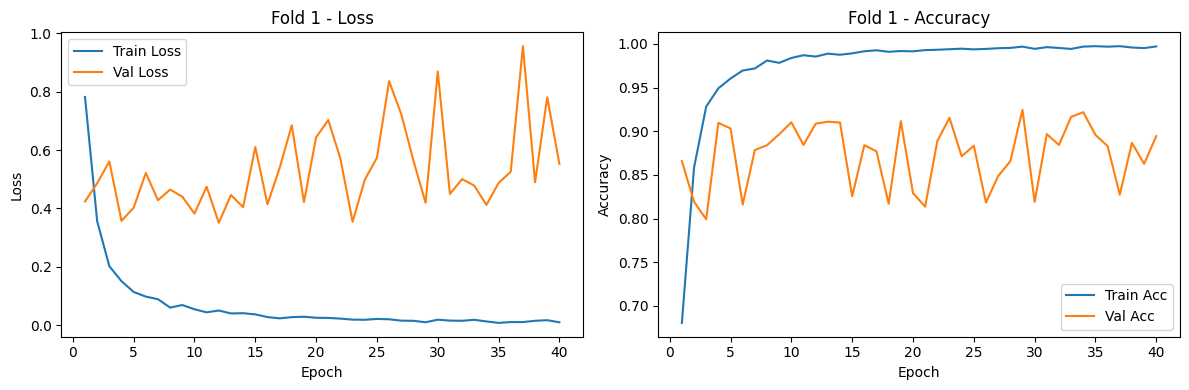

Fold 1 Accuracy: 0.8945

===== Fold 2 =====
Epoch 01 | Train Loss: 0.7527, Acc: 0.7111 | Val Loss: 0.5711, Acc: 0.7781
Epoch 02 | Train Loss: 0.3014, Acc: 0.8949 | Val Loss: 0.4178, Acc: 0.8599
Epoch 03 | Train Loss: 0.1914, Acc: 0.9409 | Val Loss: 0.4457, Acc: 0.8691
Epoch 04 | Train Loss: 0.1582, Acc: 0.9505 | Val Loss: 0.3880, Acc: 0.8868
Epoch 05 | Train Loss: 0.1318, Acc: 0.9573 | Val Loss: 0.6122, Acc: 0.8570
Epoch 06 | Train Loss: 0.1098, Acc: 0.9679 | Val Loss: 0.4468, Acc: 0.8859
Epoch 07 | Train Loss: 0.0868, Acc: 0.9741 | Val Loss: 0.3928, Acc: 0.8970
Epoch 08 | Train Loss: 0.0773, Acc: 0.9767 | Val Loss: 0.4314, Acc: 0.8782
Epoch 09 | Train Loss: 0.0737, Acc: 0.9768 | Val Loss: 0.5291, Acc: 0.8630
Epoch 10 | Train Loss: 0.0773, Acc: 0.9766 | Val Loss: 0.5785, Acc: 0.8637
Epoch 11 | Train Loss: 0.0616, Acc: 0.9838 | Val Loss: 0.4833, Acc: 0.8564
Epoch 12 | Train Loss: 0.0643, Acc: 0.9811 | Val Loss: 0.5231, Acc: 0.8599
Epoch 13 | Train Loss: 0.0531, Acc: 0.9857 | Val Loss: 0

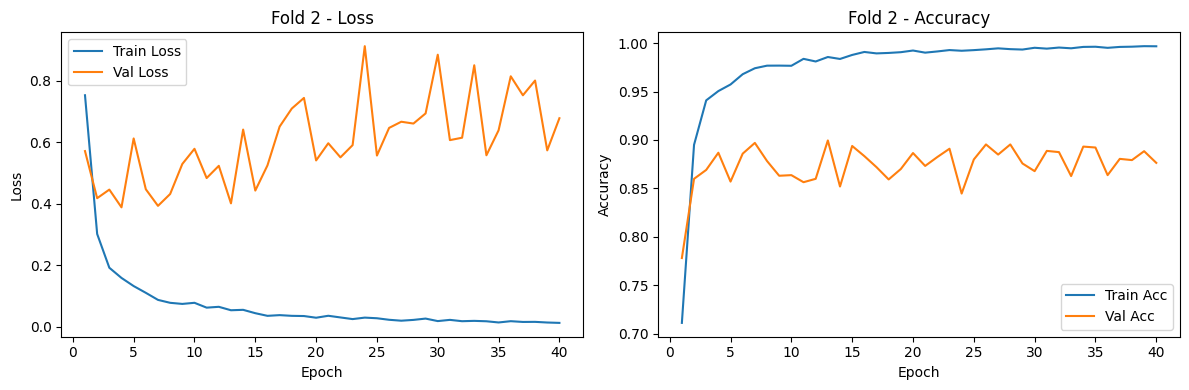

Fold 2 Accuracy: 0.8763

===== Fold 3 =====
Epoch 01 | Train Loss: 0.7155, Acc: 0.7252 | Val Loss: 0.9549, Acc: 0.6599
Epoch 02 | Train Loss: 0.2754, Acc: 0.8965 | Val Loss: 0.9211, Acc: 0.7219
Epoch 03 | Train Loss: 0.1713, Acc: 0.9430 | Val Loss: 1.3706, Acc: 0.6146
Epoch 04 | Train Loss: 0.1249, Acc: 0.9608 | Val Loss: 1.1702, Acc: 0.7088
Epoch 05 | Train Loss: 0.1024, Acc: 0.9689 | Val Loss: 0.9977, Acc: 0.7435
Epoch 06 | Train Loss: 0.0875, Acc: 0.9740 | Val Loss: 0.7119, Acc: 0.8144
Epoch 07 | Train Loss: 0.0674, Acc: 0.9806 | Val Loss: 0.8545, Acc: 0.7938
Epoch 08 | Train Loss: 0.0610, Acc: 0.9816 | Val Loss: 0.7757, Acc: 0.8024
Epoch 09 | Train Loss: 0.0584, Acc: 0.9843 | Val Loss: 1.1775, Acc: 0.7558
Epoch 10 | Train Loss: 0.0602, Acc: 0.9825 | Val Loss: 1.1044, Acc: 0.7549
Epoch 11 | Train Loss: 0.0500, Acc: 0.9846 | Val Loss: 1.2957, Acc: 0.7319
Epoch 12 | Train Loss: 0.0469, Acc: 0.9877 | Val Loss: 0.8352, Acc: 0.8272
Epoch 13 | Train Loss: 0.0414, Acc: 0.9889 | Val Loss: 1

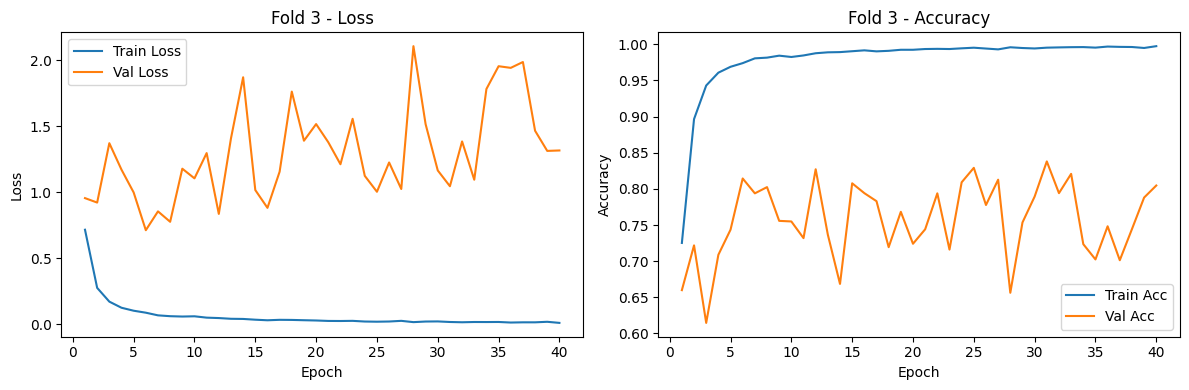

Fold 3 Accuracy: 0.8047

===== Fold 4 =====
Epoch 01 | Train Loss: 0.7327, Acc: 0.7154 | Val Loss: 0.9234, Acc: 0.7077
Epoch 02 | Train Loss: 0.2661, Acc: 0.9067 | Val Loss: 1.0244, Acc: 0.7050
Epoch 03 | Train Loss: 0.1590, Acc: 0.9465 | Val Loss: 0.9583, Acc: 0.7587
Epoch 04 | Train Loss: 0.1168, Acc: 0.9661 | Val Loss: 0.9687, Acc: 0.7873
Epoch 05 | Train Loss: 0.0985, Acc: 0.9697 | Val Loss: 1.2327, Acc: 0.7065
Epoch 06 | Train Loss: 0.0743, Acc: 0.9781 | Val Loss: 0.9816, Acc: 0.7919
Epoch 07 | Train Loss: 0.0815, Acc: 0.9759 | Val Loss: 1.1737, Acc: 0.7621
Epoch 08 | Train Loss: 0.0670, Acc: 0.9815 | Val Loss: 1.2773, Acc: 0.7109
Epoch 09 | Train Loss: 0.0626, Acc: 0.9829 | Val Loss: 1.2625, Acc: 0.7310
Epoch 10 | Train Loss: 0.0485, Acc: 0.9865 | Val Loss: 1.2371, Acc: 0.7533
Epoch 11 | Train Loss: 0.0441, Acc: 0.9876 | Val Loss: 1.0255, Acc: 0.7842
Epoch 12 | Train Loss: 0.0420, Acc: 0.9883 | Val Loss: 1.3514, Acc: 0.7325
Epoch 13 | Train Loss: 0.0394, Acc: 0.9881 | Val Loss: 1

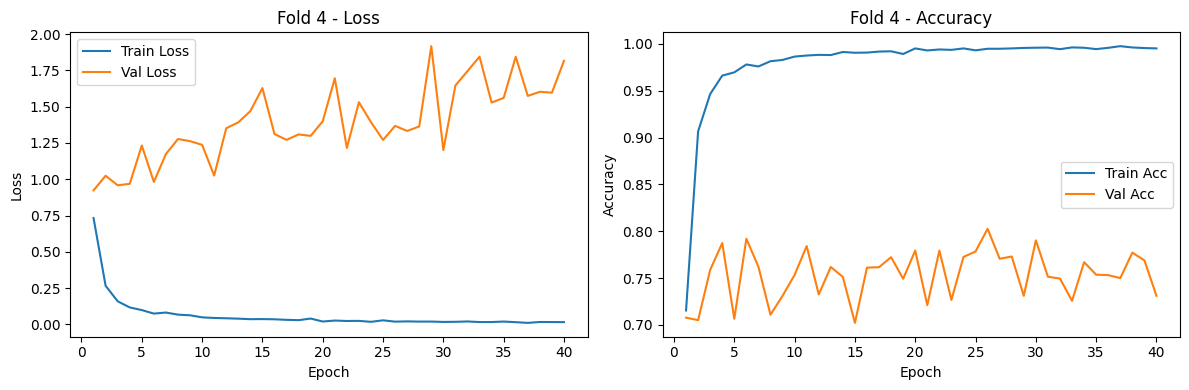

Fold 4 Accuracy: 0.7310

===== Fold 5 =====
Epoch 01 | Train Loss: 0.7584, Acc: 0.7031 | Val Loss: 0.7518, Acc: 0.6984
Epoch 02 | Train Loss: 0.2904, Acc: 0.8972 | Val Loss: 0.5347, Acc: 0.8445
Epoch 03 | Train Loss: 0.1921, Acc: 0.9376 | Val Loss: 0.4864, Acc: 0.8432
Epoch 04 | Train Loss: 0.1316, Acc: 0.9582 | Val Loss: 0.7389, Acc: 0.7652
Epoch 05 | Train Loss: 0.1186, Acc: 0.9640 | Val Loss: 0.6552, Acc: 0.8029
Epoch 06 | Train Loss: 0.0987, Acc: 0.9685 | Val Loss: 0.9307, Acc: 0.7391
Epoch 07 | Train Loss: 0.0840, Acc: 0.9740 | Val Loss: 0.8434, Acc: 0.7811
Epoch 08 | Train Loss: 0.0689, Acc: 0.9805 | Val Loss: 0.6961, Acc: 0.8385
Epoch 09 | Train Loss: 0.0659, Acc: 0.9798 | Val Loss: 0.6589, Acc: 0.8520
Epoch 10 | Train Loss: 0.0564, Acc: 0.9834 | Val Loss: 0.6370, Acc: 0.8683
Epoch 11 | Train Loss: 0.0517, Acc: 0.9847 | Val Loss: 0.9173, Acc: 0.8089
Epoch 12 | Train Loss: 0.0549, Acc: 0.9845 | Val Loss: 0.7590, Acc: 0.8280
Epoch 13 | Train Loss: 0.0455, Acc: 0.9869 | Val Loss: 0

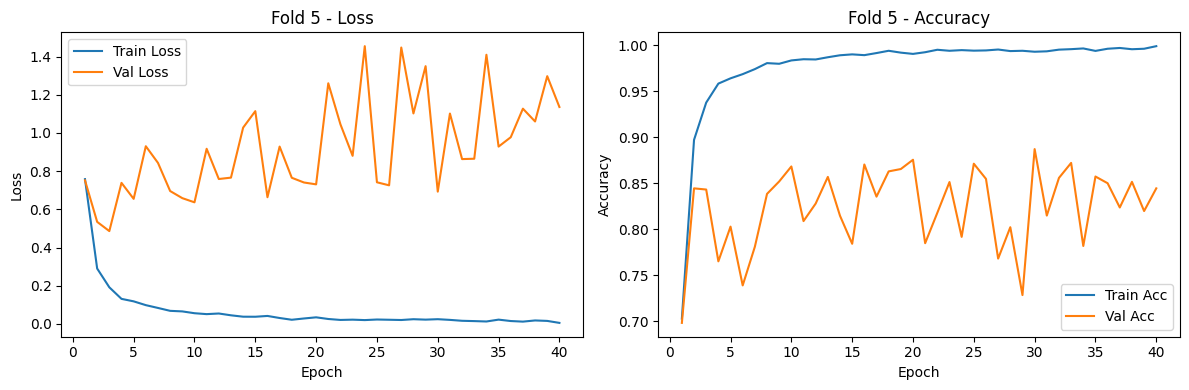

Fold 5 Accuracy: 0.8445

=== K-Fold 평균 정확도 ===
Mean Acc: 0.8302, Std: 0.0582


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

saved_states  = []
saved_scalers = [] 
fold_accs = []   

for fold in range(5):
    print(f"\n===== Fold {fold+1} =====")
    train_loader, val_loader, fold_scaler = get_fold_loaders(fold, batch_size=128)
    
    model = CNN_LSTM(num_classes=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    # 클래스 가중치 (train fold 기준)
    y_train_fold = np.array([y for _, y in train_loader.dataset])
    classes, counts = np.unique(y_train_fold, return_counts=True)
    weights = (counts.sum() / (len(classes) * counts)).astype(np.float32)
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
    
    criterion = nn.CrossEntropyLoss()

    # 학습 (히스토리 저장)
    history = train_model(model, train_loader, val_loader, epochs=40)

    # fold별 모델 state 저장
    saved_states.append(model.state_dict())
    saved_scalers.append(fold_scaler)

    # 시각화
    epochs = range(1, len(history["train_loss"])+1)
    plt.figure(figsize=(12,4))

    # Loss 곡선
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title(f"Fold {fold+1} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(False)

    # Accuracy 곡선
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.title(f"Fold {fold+1} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(False)

    plt.tight_layout()
    plt.show()
    
    # fold 성능 저장
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(yb).sum().item()
            val_total += yb.size(0)
    acc = val_correct / val_total
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")
    fold_accs.append(acc)

print("\n=== K-Fold 평균 정확도 ===")
print(f"Mean Acc: {np.mean(fold_accs):.4f}, Std: {np.std(fold_accs):.4f}")

## Check class distribution by Fold

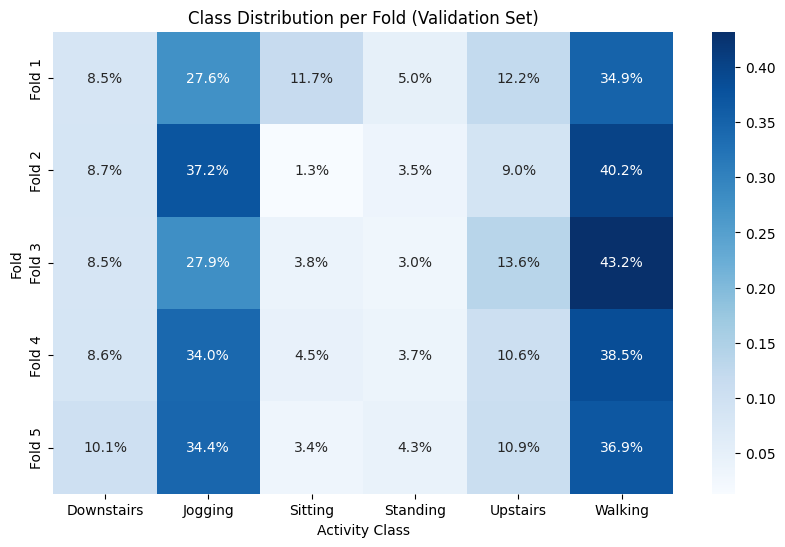

In [17]:
dist_per_fold = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    y_val = y[val_idx]
    counts = pd.Series(y_val).value_counts(normalize=True).sort_index()
    dist_per_fold.append(counts)

dist_df = pd.DataFrame(dist_per_fold).fillna(0)
dist_df.index = [f"Fold {i+1}" for i in range(len(dist_df))]
dist_df.columns = le.classes_  # activity 이름으로 열 바꾸기

plt.figure(figsize=(10,6))
sns.heatmap(dist_df, annot=True, fmt=".1%", cmap="Blues")
plt.title("Class Distribution per Fold (Validation Set)")
plt.ylabel("Fold")
plt.xlabel("Activity Class")
plt.show()

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM(num_classes=6).to(device)
print(device)
print(model)

cuda
CNN_LSTM(
  (conv1): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AdaptiveAvgPool1d(output_size=40)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(128, 256, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)


## Model Evaluation

In [18]:
# 원본 test를 보존
X_test_raw = X_test.copy()

probs_list = []
for fold, (state, scaler_f) in enumerate(zip(saved_states, saved_scalers)):
    # ★ fold의 scaler로 test 변환
    X_test_fold = scaler_f.transform(X_test_raw.reshape(-1, C)).reshape(-1, T, C)

    test_ds_fold = TensorDataset(torch.tensor(X_test_fold, dtype=torch.float32),
                                 torch.tensor(y_test, dtype=torch.long))
    test_loader_fold = DataLoader(test_ds_fold, batch_size=128, shuffle=False)

    model = CNN_LSTM(num_classes=6).to(device)
    model.load_state_dict(state)
    model.eval()

    all_probs = []
    with torch.no_grad():
        for xb, _ in test_loader_fold:
            xb = xb.to(device)
            outputs = model(xb)        # log_softmax
            probs = F.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
    probs_list.append(np.vstack(all_probs))



Ensemble Test Accuracy: 0.8779


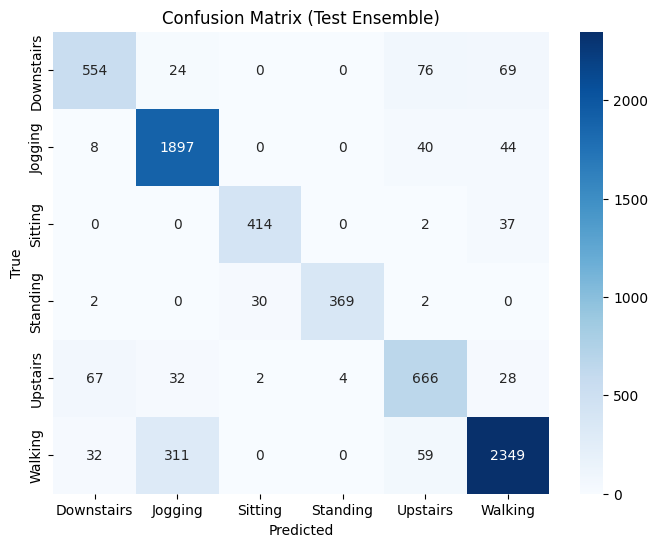


Classification Report (Test Ensemble)
              precision    recall  f1-score   support

  Downstairs       0.84      0.77      0.80       723
     Jogging       0.84      0.95      0.89      1989
     Sitting       0.93      0.91      0.92       453
    Standing       0.99      0.92      0.95       403
    Upstairs       0.79      0.83      0.81       799
     Walking       0.93      0.85      0.89      2751

    accuracy                           0.88      7118
   macro avg       0.88      0.87      0.88      7118
weighted avg       0.88      0.88      0.88      7118



In [19]:
# 앙상블 확률 평균 → 최종 예측
avg_probs = np.mean(probs_list, axis=0)
final_preds = np.argmax(avg_probs, axis=1)

test_acc = accuracy_score(y_test, final_preds)
print(f"\nEnsemble Test Accuracy: {test_acc:.4f}")

cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (Test Ensemble)")
plt.show()

print("\nClassification Report (Test Ensemble)")
print(classification_report(y_test, final_preds, target_names=le.classes_))